## 기본 라이브러리 불러오기

In [231]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import chardet

# 사용자 정의함수 경로 설정
import sys
sys.path.append("G:/내 드라이브/Source/_Custom_Function")
# 사용자 정의함수 불러오기

pd.set_option('display.max_column', None)

import time

import ExcelFile_Merge as em
import ExcelFile_Read as er
import ExcelFile_EDA as ee

---
## 이상치패턴 저장데이터 다시 불러오기

In [234]:
start_time = time.time()
df_outlier_rental = pd.read_parquet('G:\\내 드라이브\\DataSet\\_파킷 파일\\서울특별시 공공자전거 대여이력 정보\\서울특별시 공공자전거 대여이력 정보_(PRE)고장예측_2023_2024_20241107.parquet')
print("read_csv time :", time.time() - start_time)

read_csv time : 0.022797107696533203


In [236]:
df_outlier_rental.head()

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수
0,SPB-30006,2024-02-29,2024-03-31,페달,1,2,98170.92,843.0,74.0
1,SPB-30010,2024-05-18,2024-06-18,타이어,1,5,231653.56,2257.0,121.0
2,SPB-30014,2024-05-24,2024-06-24,기타,1,7,335138.54,2966.0,156.0
3,SPB-30018,2024-05-01,2024-06-01,기타,1,2,291259.65,3041.0,153.0
4,SPB-30022,2024-04-20,2024-05-20,기타,1,7,253399.66,2755.0,143.0


In [238]:
df_outlier_rental['고장여부'].value_counts()

고장여부
1    28589
0    13307
Name: count, dtype: int64

---
## 23년 자전거대여 월별집계 내역 불러오기

In [241]:
start_time = time.time()
df_2023_rental = pd.read_parquet('G:\\내 드라이브\\DataSet\\_파킷 파일\\서울특별시 공공자전거 대여이력 정보\\서울특별시 공공자전거 대여이력 정보_(PRE)2023_자전거별_월별_집계.parquet')
print("read_csv time :", time.time() - start_time)

read_csv time : 0.05776619911193848


In [243]:
df_2023_rental.shape[0]

43833

In [245]:
df_2023_rental.head(5)

,자전거번호,대여일자_count_1,대여일자_count_2,대여일자_count_3,대여일자_count_4,대여일자_count_5,대여일자_count_6,대여일자_count_7,대여일자_count_8,대여일자_count_9,대여일자_count_10,대여일자_count_11,대여일자_count_12,이용거리(M)_mean_1,이용거리(M)_mean_2,이용거리(M)_mean_3,이용거리(M)_mean_4,이용거리(M)_mean_5,이용거리(M)_mean_6,이용거리(M)_mean_7,이용거리(M)_mean_8,이용거리(M)_mean_9,이용거리(M)_mean_10,이용거리(M)_mean_11,이용거리(M)_mean_12,이용거리(M)_sum_1,이용거리(M)_sum_2,이용거리(M)_sum_3,이용거리(M)_sum_4,이용거리(M)_sum_5,이용거리(M)_sum_6,이용거리(M)_sum_7,이용거리(M)_sum_8,이용거리(M)_sum_9,이용거리(M)_sum_10,이용거리(M)_sum_11,이용거리(M)_sum_12,이용시간(분)_mean_1,이용시간(분)_mean_2,이용시간(분)_mean_3,이용시간(분)_mean_4,이용시간(분)_mean_5,이용시간(분)_mean_6,이용시간(분)_mean_7,이용시간(분)_mean_8,이용시간(분)_mean_9,이용시간(분)_mean_10,이용시간(분)_mean_11,이용시간(분)_mean_12,이용시간(분)_sum_1,이용시간(분)_sum_2,이용시간(분)_sum_3,이용시간(분)_sum_4,이용시간(분)_sum_5,이용시간(분)_sum_6,이용시간(분)_sum_7,이용시간(분)_sum_8,이용시간(분)_sum_9,이용시간(분)_sum_10,이용시간(분)_sum_11,이용시간(분)_sum_12,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean)
0,SPB-30001,126.0,111.0,195.0,104.0,121.0,162.0,141.0,119.0,175.0,123.0,117.0,46.0,1597.532540,2360.263423,2401.844256,3938.884712,2607.534463,2265.619877,2449.579078,1754.730588,2441.748571,2058.824472,1395.287778,1805.492174,201289.10,261989.24,468359.63,409644.01,315511.67,367030.42,345390.65,208812.94,427306.00,253235.41,163248.67,83052.64,14.079365,20.306306,19.205128,34.375000,20.727273,18.709877,21.680851,15.126050,21.040000,19.593496,18.564103,20.108696,1774.0,2254.0,3745.0,3575.0,2508.0,3031.0,3057.0,1800.0,3682.0,2410.0,2172.0,925.0,128.333333,2256.445161,292072.531667
1,SPB-30006,11.0,80.0,150.0,139.0,199.0,193.0,202.0,143.0,125.0,159.0,31.0,110.0,1468.723636,1717.237500,1920.765200,1798.489065,2225.908141,2427.211295,2482.220149,1585.403357,2791.540560,2172.033459,2026.211290,1124.839455,16155.96,137379.00,288114.78,249989.98,442955.72,468451.78,501408.47,226712.68,348942.57,345353.32,62812.55,123732.34,10.636364,17.650000,18.473333,20.064748,18.788945,22.217617,21.465347,17.524476,25.064000,19.396226,19.451613,11.436364,117.0,1412.0,2771.0,2789.0,3739.0,4288.0,4336.0,2506.0,3133.0,3084.0,603.0,1258.0,128.500000,1978.381926,267667.429167
2,SPB-30008,42.0,42.0,19.0,83.0,181.0,120.0,143.0,179.0,116.0,105.0,93.0,40.0,1222.382143,1878.965714,2277.800000,1902.278434,2182.769006,2227.949083,2630.634406,3092.678212,2912.774914,2275.691524,2009.036559,2134.287750,51340.05,78916.56,43278.20,157889.11,395081.19,267353.89,376180.72,553589.40,337881.89,238947.61,186840.40,85371.51,11.976190,15.785714,19.315789,14.228916,16.508287,16.083333,20.923077,22.312849,22.620690,21.133333,19.978495,20.675000,503.0,663.0,367.0,1181.0,2988.0,1930.0,2992.0,3994.0,2624.0,2219.0,1858.0,827.0,96.916667,2228.937312,231055.877500
3,SPB-30009,NaN,70.0,111.0,172.0,20.0,12.0,49.0,117.0,78.0,94.0,NaN,NaN,NaN,2058.221429,1763.318829,2071.568488,3322.989000,2160.264167,1741.867347,1863.074444,2127.794615,1845.711702,NaN,NaN,NaN,144075.50,195728.39,356309.78,66459.78,25923.17,85351.50,217979.71,165967.98,173496.90,NaN,NaN,NaN,15.542857,18.639640,18.023256,32.100000,60.416667,13.836735,25.111111,22.397436,23.712766,NaN,NaN,NaN,1088.0,2069.0,3100.0,642.0,725.0,678.0,2938.0,1747.0,2229.0,NaN,NaN,80.333333,2106.090002,159032.523333
4,SPB-30010,65.0,115.0,151.0,167.0,163.0,234.0,151.0,102.0,135.0,150.0,51.0,37.0,1336.259538,1630.415913,1733.082848,1947.733293,1720.982454,2153.064017,1968.328874,1885.984510,2117.909704,1928.055867,1192.914902,1635.178919,86856.87,187497.83,261695.51,325271.46,280520.14,503816.98,297217.66,192370.42,285917.81,289208.38,60838.66,60501.62,14.907692,15.069565,16.993377,18.802395,20.294479,18.598291,16.827815,14.715686,15.896296,16.053333,12.588235,15.675676,969.0,1733.0,2566.0,3140.0,3308.0,4352.0,2541.0,1501.0,2146.0,2408.0,642.0,580.0,126.750000,1770.825903,235976.111667


In [247]:
df_2023_rental.columns

Index(['자전거번호', '대여일자_count_1', '대여일자_count_2', '대여일자_count_3', '대여일자_count_4',
       '대여일자_count_5', '대여일자_count_6', '대여일자_count_7', '대여일자_count_8',
       '대여일자_count_9', '대여일자_count_10', '대여일자_count_11', '대여일자_count_12',
       '이용거리(M)_mean_1', '이용거리(M)_mean_2', '이용거리(M)_mean_3', '이용거리(M)_mean_4',
       '이용거리(M)_mean_5', '이용거리(M)_mean_6', '이용거리(M)_mean_7', '이용거리(M)_mean_8',
       '이용거리(M)_mean_9', '이용거리(M)_mean_10', '이용거리(M)_mean_11',
       '이용거리(M)_mean_12', '이용거리(M)_sum_1', '이용거리(M)_sum_2', '이용거리(M)_sum_3',
       '이용거리(M)_sum_4', '이용거리(M)_sum_5', '이용거리(M)_sum_6', '이용거리(M)_sum_7',
       '이용거리(M)_sum_8', '이용거리(M)_sum_9', '이용거리(M)_sum_10', '이용거리(M)_sum_11',
       '이용거리(M)_sum_12', '이용시간(분)_mean_1', '이용시간(분)_mean_2', '이용시간(분)_mean_3',
       '이용시간(분)_mean_4', '이용시간(분)_mean_5', '이용시간(분)_mean_6', '이용시간(분)_mean_7',
       '이용시간(분)_mean_8', '이용시간(분)_mean_9', '이용시간(분)_mean_10',
       '이용시간(분)_mean_11', '이용시간(분)_mean_12', '이용시간(분)_sum_1', '이용시간(분)_sum_2',
       '이용시간(분)_sum_3', '이

In [249]:
df_2023_rental = df_2023_rental[['자전거번호', '대여일자_count(mean)', '이용거리(M)_mean(mean)', '이용거리(M)_sum(mean)']]

In [251]:
df_outlier_rental = pd.merge(df_outlier_rental, df_2023_rental, on='자전거번호', how='inner')

In [253]:
df_outlier_rental.head()

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean)
0,SPB-30006,2024-02-29,2024-03-31,페달,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167
1,SPB-30010,2024-05-18,2024-06-18,타이어,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667
2,SPB-30014,2024-05-24,2024-06-24,기타,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455
3,SPB-30018,2024-05-01,2024-06-01,기타,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364
4,SPB-30022,2024-04-20,2024-05-20,기타,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000


In [255]:
df_outlier_rental.isnull().sum()

자전거번호                  0
이전일자_1mon              0
등록대여일자                 0
고장구분                   0
고장여부                   0
이상패턴_5min_횟수           0
이전일자_1mon_이용거리        51
이전일자_1mon_이용시간        51
이전일자_1mon_이용횟수        51
대여일자_count(mean)       0
이용거리(M)_mean(mean)     0
이용거리(M)_sum(mean)      0
dtype: int64

In [257]:
df_outlier_rental['이용횟수_비교'] = ee.ss_compare(df_outlier_rental['대여일자_count(mean)'], df_outlier_rental['이전일자_1mon_이용횟수'])
df_outlier_rental['이용거리_비교'] = ee.ss_compare(df_outlier_rental['이용거리(M)_sum(mean)'], df_outlier_rental['이전일자_1mon_이용거리'])

In [259]:
df_outlier_rental.head()

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
0,SPB-30006,2024-02-29,2024-03-31,페달,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167,-42.41,-63.32
1,SPB-30010,2024-05-18,2024-06-18,타이어,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667,-4.54,-1.83
2,SPB-30014,2024-05-24,2024-06-24,기타,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455,54.46,45.17
3,SPB-30018,2024-05-01,2024-06-01,기타,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364,80.77,75.37
4,SPB-30022,2024-04-20,2024-05-20,기타,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000,84.99,84.98


In [261]:
df_Bike_latest_2 = df_outlier_rental

In [263]:
df_Bike_latest_2.head()

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
0,SPB-30006,2024-02-29,2024-03-31,페달,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167,-42.41,-63.32
1,SPB-30010,2024-05-18,2024-06-18,타이어,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667,-4.54,-1.83
2,SPB-30014,2024-05-24,2024-06-24,기타,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455,54.46,45.17
3,SPB-30018,2024-05-01,2024-06-01,기타,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364,80.77,75.37
4,SPB-30022,2024-04-20,2024-05-20,기타,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000,84.99,84.98


---
## 고장횟수 별 - 고장비율
 - 고장 : 24년의 마지막고장신고
 - 정상 : 24년의 마지막 대여일

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

### [전체] 고장여부 비율

In [269]:
counts = df_Bike_latest_2['고장여부'].value_counts()
total = counts.sum()   # 총 데이터 개수
percentage = counts / total * 100   # 비율 계산
print(f'total : {total}')
print(f'counts : {counts}')
print(f'percentage : {percentage}')

total : 41561
counts : 고장여부
1    28418
0    13143
Name: count, dtype: int64
percentage : 고장여부
1    68.376603
0    31.623397
Name: count, dtype: float64


---
## 고장여부 에 따른 고장횟수

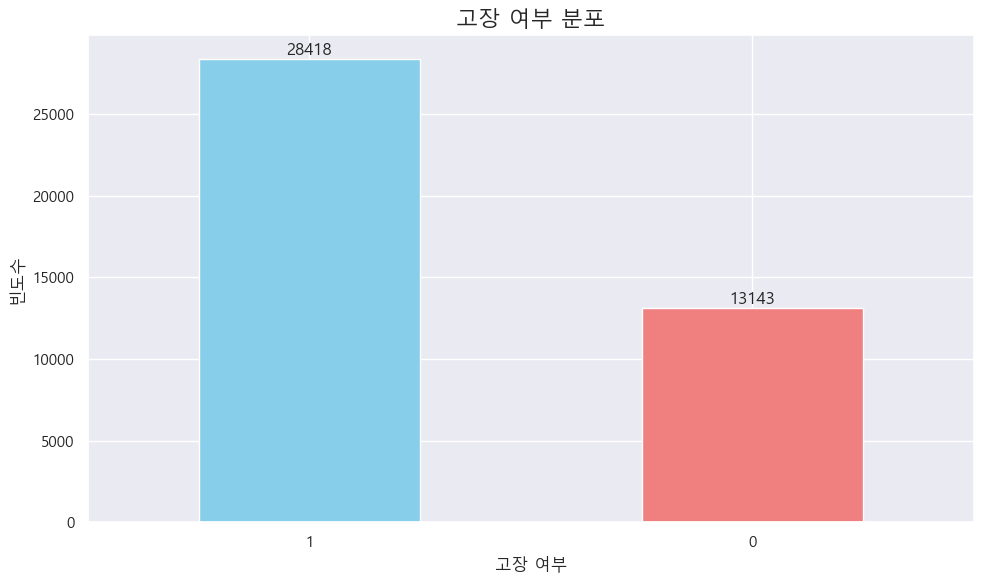

In [272]:
# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 준비
gojang_counts = df_Bike_latest_2['고장여부'].value_counts()
# 그래프 크기 설정
plt.figure(figsize=(10, 6))
# 막대 그래프 그리기
gojang_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
# 그래프 꾸미기
plt.title('고장 여부 분포', fontsize=16)
plt.xlabel('고장 여부', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.xticks(rotation=0)

# 각 막대 위에 값 표시
for i, v in enumerate(gojang_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 결측치 확인

In [275]:
df_Bike_latest_2.isnull().sum()

자전거번호                  0
이전일자_1mon              0
등록대여일자                 0
고장구분                   0
고장여부                   0
이상패턴_5min_횟수           0
이전일자_1mon_이용거리        51
이전일자_1mon_이용시간        51
이전일자_1mon_이용횟수        51
대여일자_count(mean)       0
이용거리(M)_mean(mean)     0
이용거리(M)_sum(mean)      0
이용횟수_비교               51
이용거리_비교               51
dtype: int64

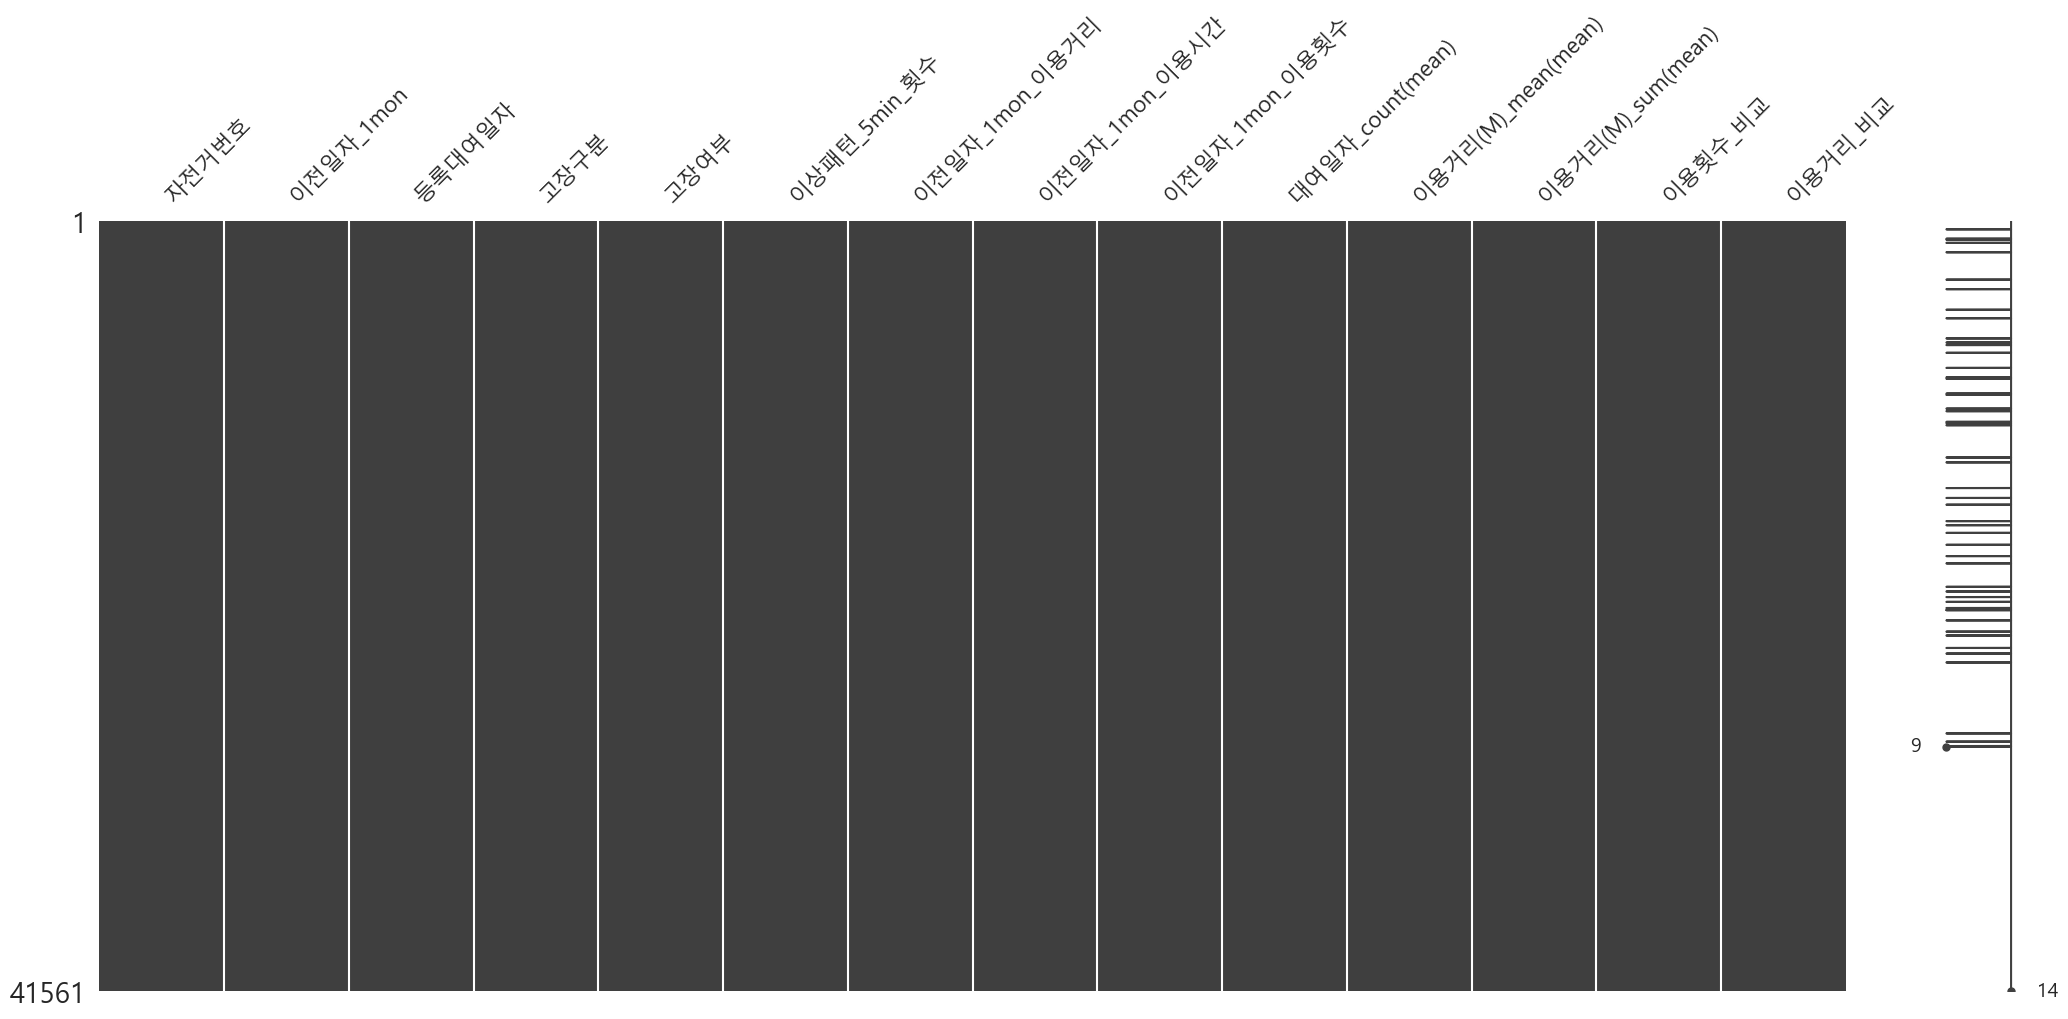

In [277]:
import missingno as msno
# 결측치 매트릭스 시각화
msno.matrix(df_Bike_latest_2)
plt.show()

---
### 중복제거

In [280]:
df_Bike_latest_3 = df_Bike_latest_2.dropna()

---
### subplot multi 함수선언

In [283]:
# 서브플롯 생성 함수
def create_multi_subplot(_df, _columns):
    plt.figure(figsize=(12, 6))
    
    # 전체 데이터에서 x축 범위 계산
    x_min = min(_df[_columns[0]].min(),
                _df[_columns[1]].min(),
                _df[_columns[2]].min())
    x_max = max(_df[_columns[0]].max(),
                _df[_columns[1]].max(),
                _df[_columns[2]].max())

    # 최대 빈도수 계산
    max_count = 0
    for j in [0, 1]:
        for _column in _columns:
            data = _df[_df['고장여부'] == j][_column]
            counts, _ = np.histogram(data, bins=10)
            max_count = max(max_count, counts.max())

    
    position = 1
    for j in list(range(0, 2)):
        for i, _column in enumerate(_columns):
            data = _df[_df['고장여부'] == j][_column]
            title = f'(고장={str(j)}) {_column} 분포'
            xlabel = _column
            _color = 'lightgreen' if j== 1 else 'skyblue'
            
            plt.subplot(2, 3, position)
            sns.histplot(data, bins=10, kde=True, color=_color)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('빈도수')
            plt.xlim(x_min, x_max)
            plt.ylim(0, max_count * 1.1)  # y축 범위 통일
            
            # x축의 지수 표현 제거
            #plt.ticklabel_format(axis="x", style="plain")
    
            position = position + 1
    
    plt.tight_layout()
    plt.show()


In [285]:
# 서브플롯 생성 함수
def create_bi_subplot(_df, _columns):
    plt.figure(figsize=(15, 6))
    
    # 전체 데이터에서 x축 범위 계산
    # x_min = min(_df[_columns[0]].min(),
    #             _df[_columns[1]].min(),
    #             _df[_columns[2]].min())
    # x_max = max(_df[_columns[0]].max(),
    #             _df[_columns[1]].max(),
    #             _df[_columns[2]].max())
    x_min = _df[_columns[0]].min()
    x_max = _df[_columns[0]].max()

    # 최대 빈도수 계산
    # max_count = 0
    # for j in [0, 1]:
    #     for _column in _columns:
    #         data = _df[_df['고장여부'] == j][_column]
    #         counts, _ = np.histogram(data, bins=10)
    #         max_count = max(max_count, counts.max())

    
    position = 1
    for j in list(range(0, 2)):
        for i, _column in enumerate(_columns):
            data = _df[_df['고장여부'] == j][_column]
            title = f'(고장={str(j)}) {_column} 분포'
            xlabel = _column
            _color = 'lightgreen' if j== 1 else 'skyblue'
            
            plt.subplot(1, 2, position)
            sns.histplot(data, bins=10, kde=True, color=_color)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('빈도수')
            #plt.xlim(x_min, x_max)
            #plt.ylim(0, max_count * 1.1)  # y축 범위 통일
            
            # x축의 지수 표현 제거
            #plt.ticklabel_format(axis="x", style="plain")
    
            position = position + 1
    
    plt.tight_layout()
    plt.show()

In [287]:
df_Bike_latest_3[df_Bike_latest_3['고장여부'] == 0].head(2)

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
28418,SPB-30001,2024-05-28,2024-06-28,,0,5,240874.96,2496.0,161.0,128.333333,2256.445161,292072.531667,25.45,-17.53
28419,SPB-30008,2024-04-20,2024-05-20,,0,0,228641.47,1732.0,87.0,96.916667,2228.937312,231055.877500,-10.23,-1.04


In [289]:
df_Bike_latest_3[df_Bike_latest_3['고장여부'] == 1].head(2)

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
0,SPB-30006,2024-02-29,2024-03-31,페달,1,2,98170.92,843.0,74.0,128.50,1978.381926,267667.429167,-42.41,-63.32
1,SPB-30010,2024-05-18,2024-06-18,타이어,1,5,231653.56,2257.0,121.0,126.75,1770.825903,235976.111667,-4.54,-1.83


In [291]:
df_Bike_latest_3.sort_values(by = '이전일자_1mon_이용횟수', ascending = False).head(5)

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
27232,SPB-70157,2024-05-21,2024-06-21,체인,1,16,1201356.35,9811.0,438.0,107.500000,1846.875322,228690.205000,307.44,425.32
27363,SPB-70354,2024-05-21,2024-06-21,체인,1,7,995194.13,8275.0,413.0,13.000000,2255.790000,29325.270000,3076.92,3293.64
30868,SPB-37999,2024-05-30,2024-06-30,,0,8,1172643.34,9934.0,413.0,161.666667,2221.576026,336175.693333,155.46,248.82
26553,SPB-69417,2024-05-19,2024-06-19,기타,1,4,1059363.64,9413.0,412.0,206.750000,2810.733309,603391.217500,99.27,75.57
20166,SPB-60686,2024-05-18,2024-06-18,기타,1,14,1099534.37,9921.0,407.0,96.571429,2211.320752,229072.335714,321.45,379.99


In [293]:
# df_Bike_latest_3.columns
_columns = ['이상패턴_5min_횟수',
       '이전일자_1mon_이용거리', '이전일자_1mon_이용시간', '이전일자_1mon_이용횟수']
grb_Bike_latest_3 = df_Bike_latest_3.groupby(['고장여부'])[_columns].agg('mean')

In [295]:
grb_Bike_latest_3.columns

Index(['이상패턴_5min_횟수', '이전일자_1mon_이용거리', '이전일자_1mon_이용시간', '이전일자_1mon_이용횟수'], dtype='object')

In [297]:
grb_Bike_latest_3.isnull().sum()

이상패턴_5min_횟수      0
이전일자_1mon_이용거리    0
이전일자_1mon_이용시간    0
이전일자_1mon_이용횟수    0
dtype: int64

---
## 이상패턴_5min_횟수(고장=1, 고장=0) 시각화

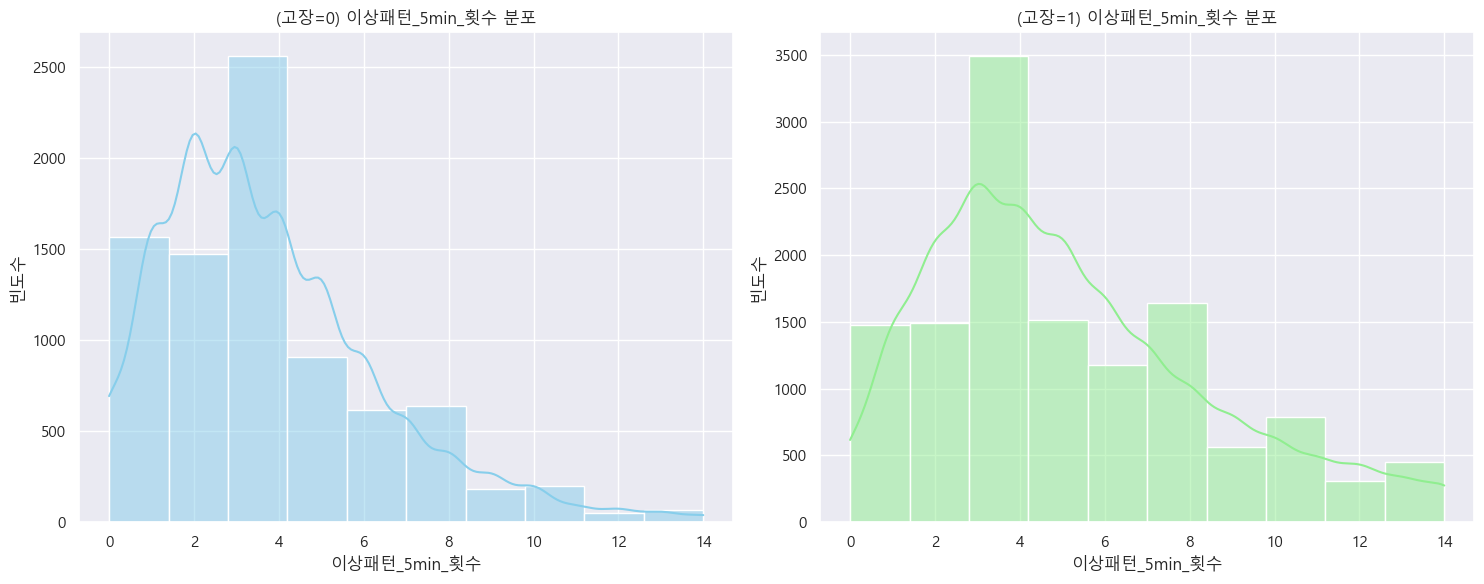

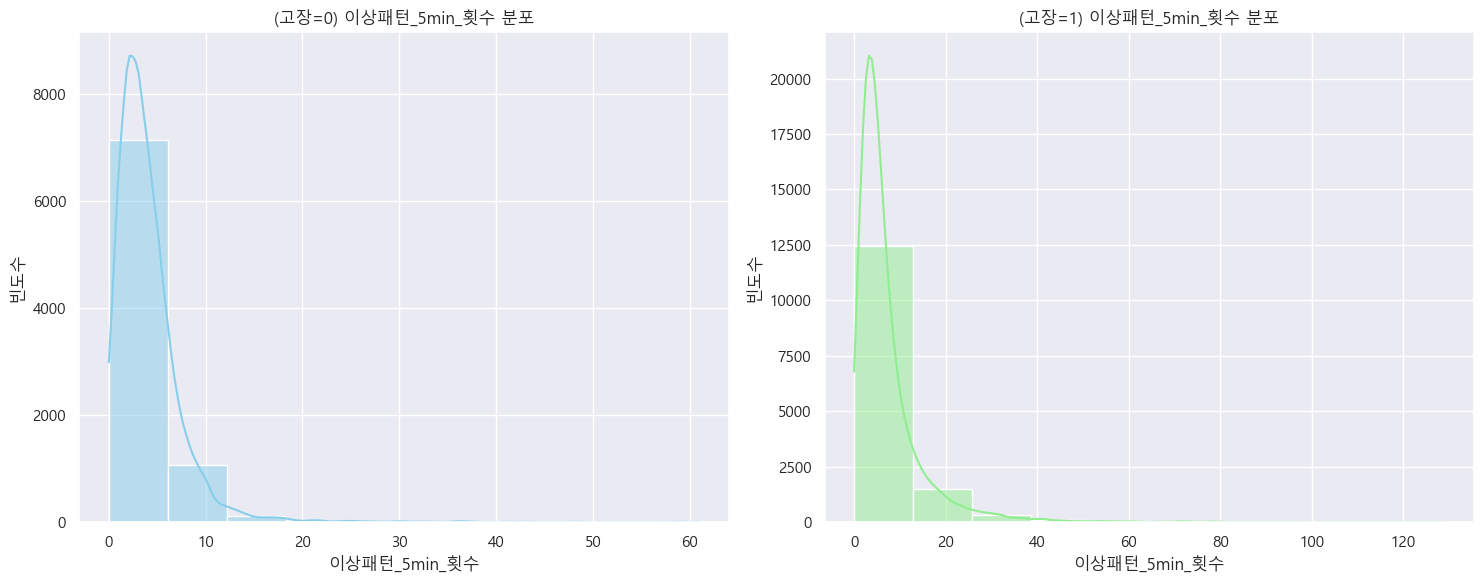

In [491]:
_columns = ['이상패턴_5min_횟수']
create_bi_subplot(check_outlier(df_Bike_latest_3, '이상패턴_5min_횟수'), _columns)
create_bi_subplot(df_Bike_latest_3, _columns)

---
## 이전일자_1mon_이용거리(고장=1, 고장=0) 시각화

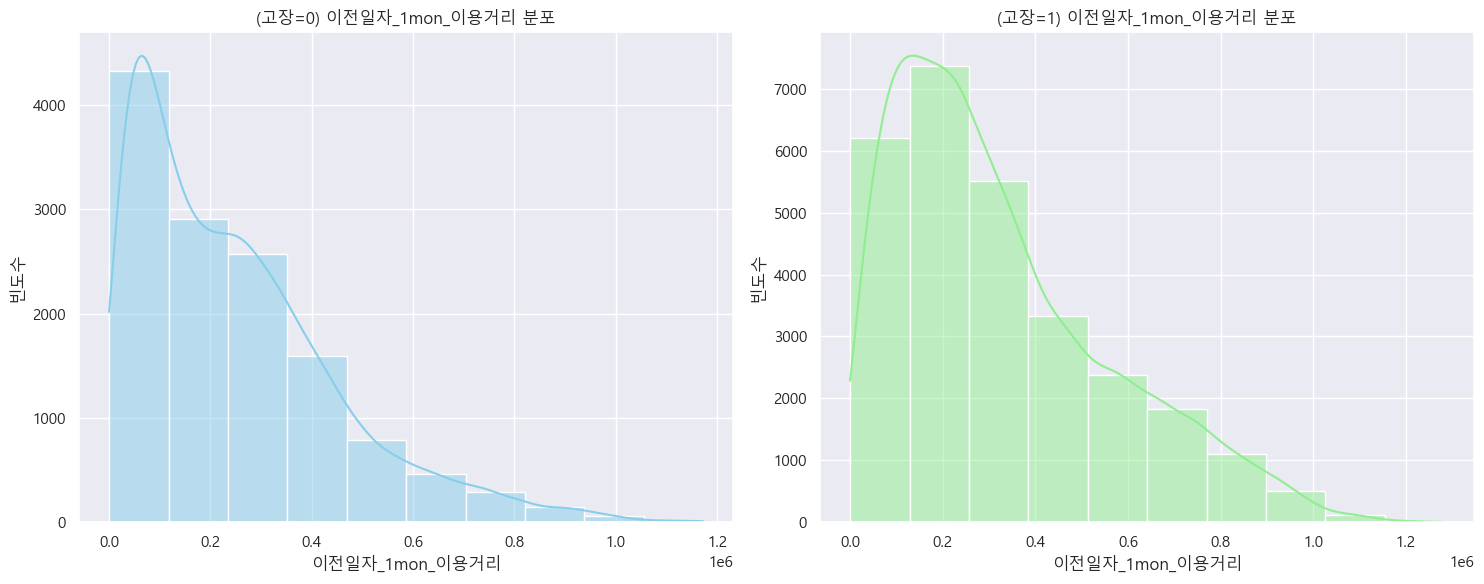

In [303]:
_columns = ['이전일자_1mon_이용거리']
create_bi_subplot(df_Bike_latest_3, _columns)

---
## 이전일자_1mon_이용시간(고장=1, 고장=0)  시각화

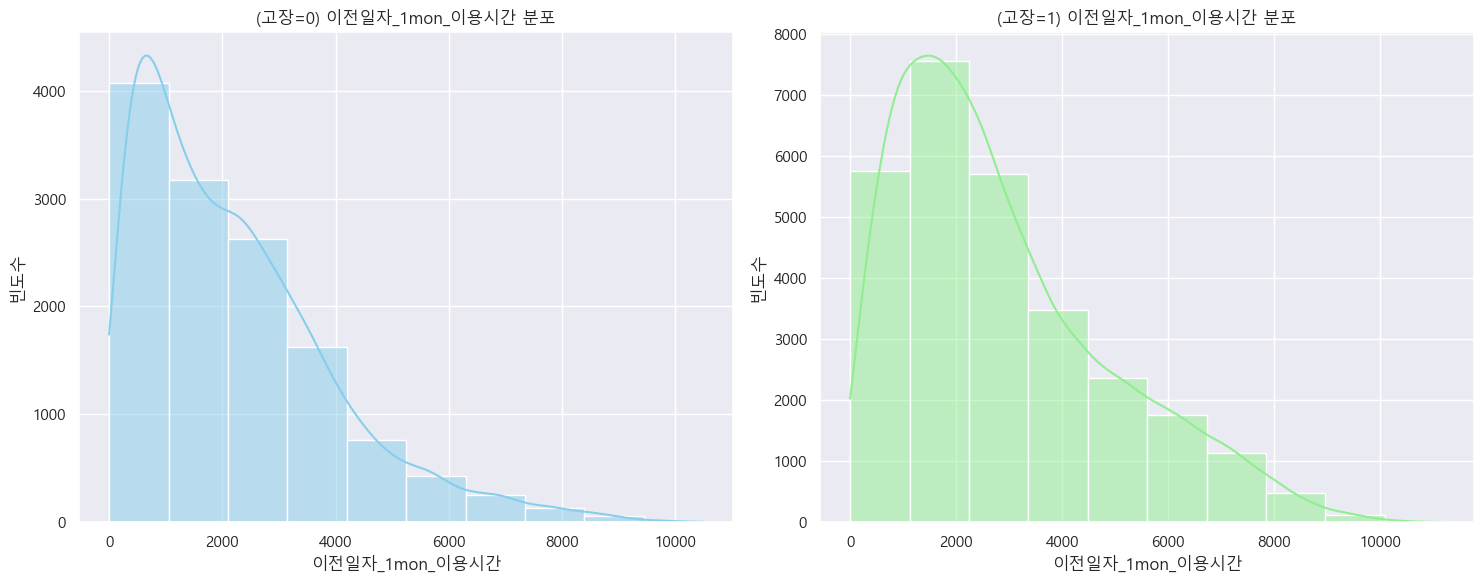

In [306]:
_columns = ['이전일자_1mon_이용시간']
create_bi_subplot(df_Bike_latest_3, _columns)

---
## 이전일자_1mon_이용횟수(고장=1, 고장=0) 시각화

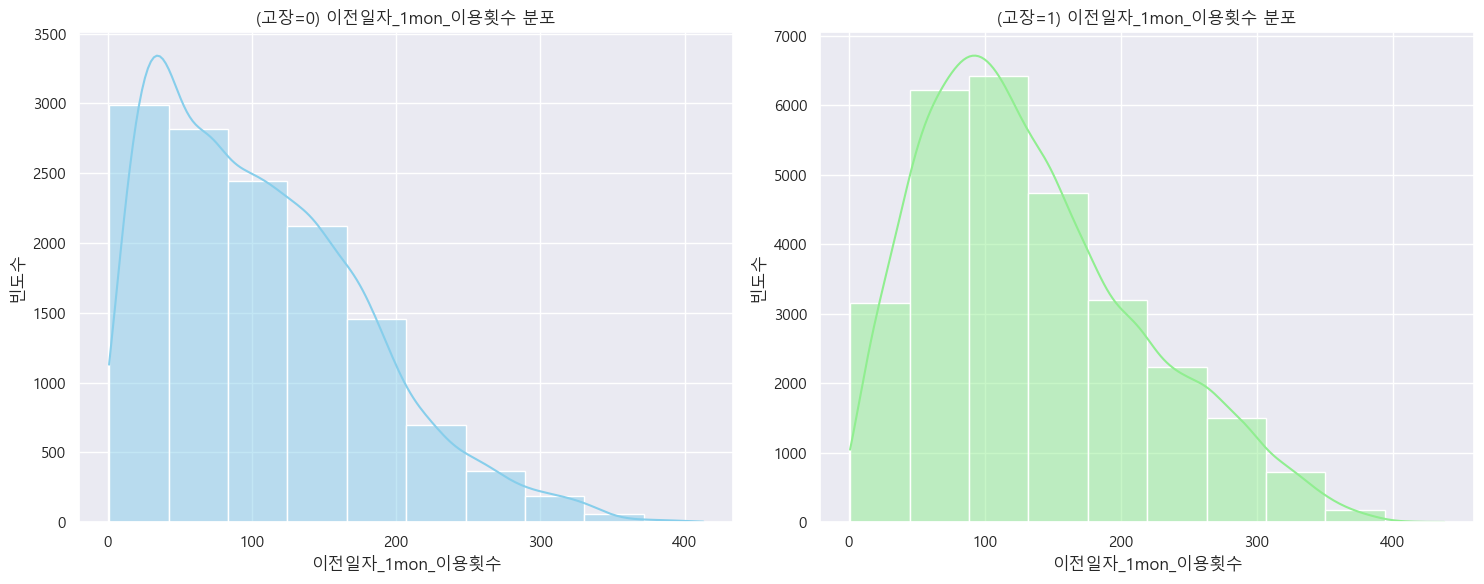

In [309]:
_columns = ['이전일자_1mon_이용횟수']
create_bi_subplot(df_Bike_latest_3, _columns)

---
## 이용횟수_비교(고장=1, 고장=0) 시각화

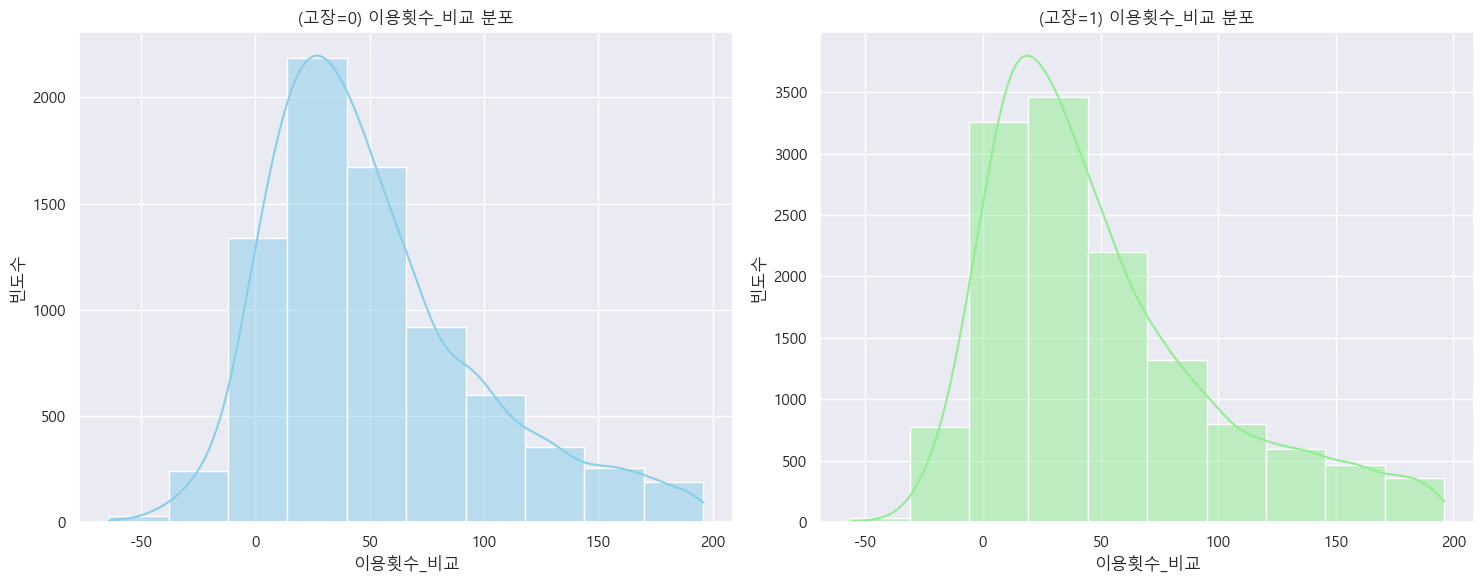

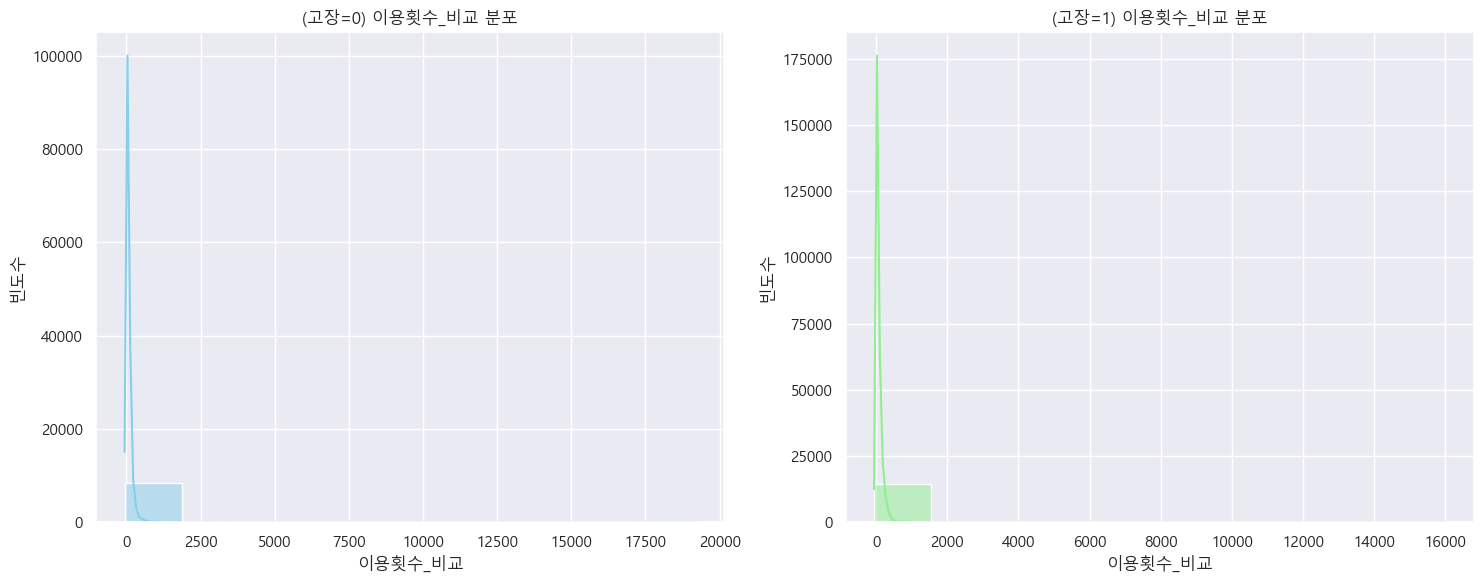

In [487]:
_columns = ['이용횟수_비교']
create_bi_subplot(check_outlier(df_Bike_latest_3, '이용횟수_비교'), _columns)
create_bi_subplot(df_Bike_latest_3, _columns)

---
## 이용거리_비교(고장=1, 고장=0) 시각화

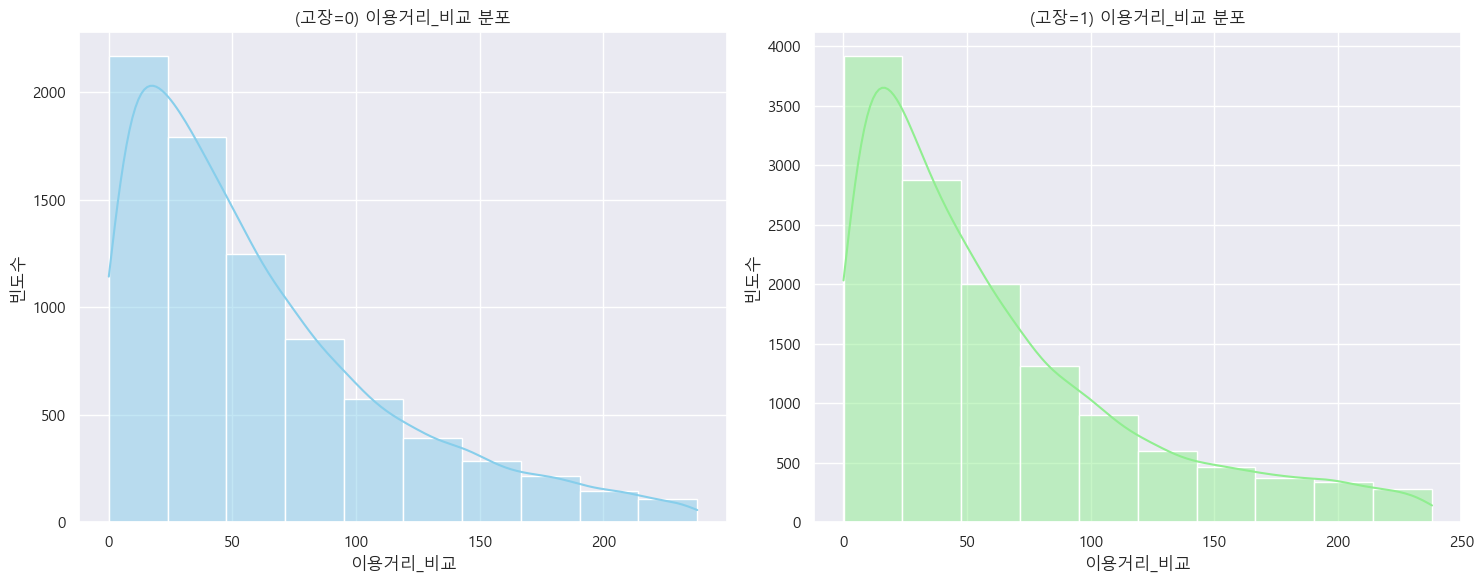

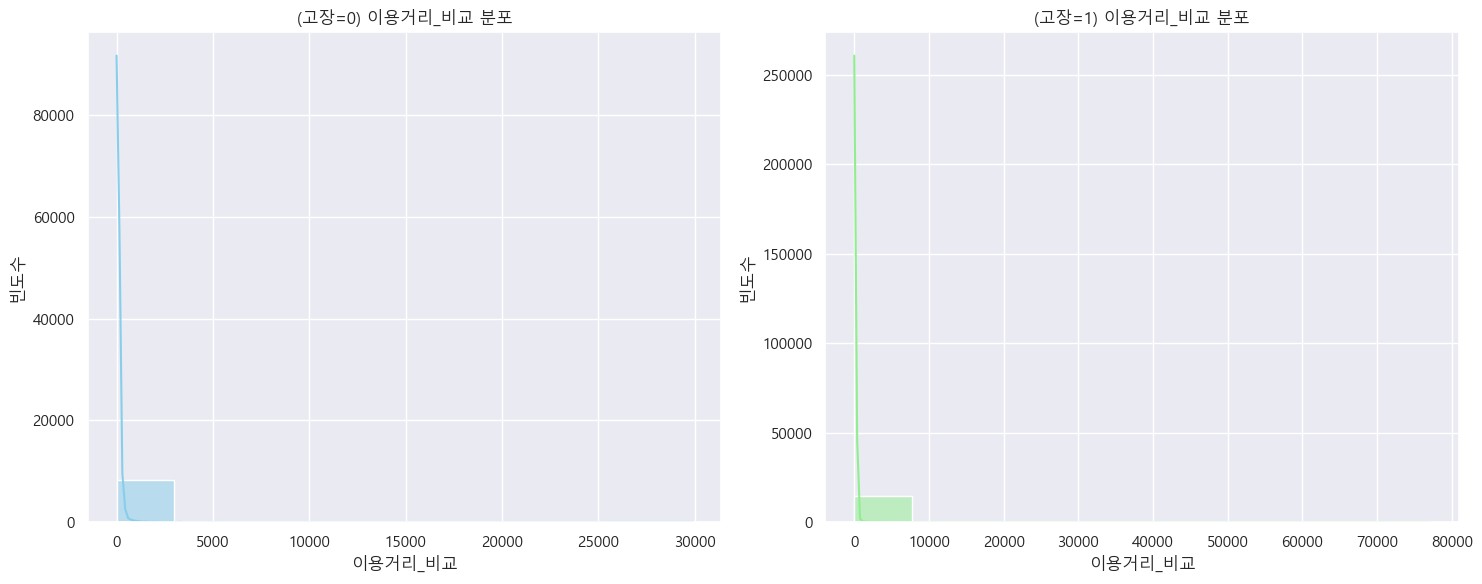

In [489]:
_columns = ['이용거리_비교']
create_bi_subplot(check_outlier(df_Bike_latest_3, '이용거리_비교'), _columns)
create_bi_subplot(df_Bike_latest_3, _columns)

In [311]:
df_Bike_latest_2['이상패턴_5min_횟수'].value_counts().sort_index()[:10]

이상패턴_5min_횟수
0    3227
1    5305
2    6147
3    5685
4    4665
5    3715
6    2758
7    1998
8    1459
9    1138
Name: count, dtype: int64

In [313]:
# 고장횟수에 따른 고장여부 비율 계산
df_2 = df_Bike_latest_2.groupby('이상패턴_5min_횟수')['고장여부'].value_counts(normalize=True).unstack().reset_index()
df_2.columns = ['이상패턴_5min_횟수', '고장', '정상']
df_2.head(10)

,이상패턴_5min_횟수,고장,정상
0,0,0.411838,0.588162
1,1,0.411310,0.588690
2,2,0.397592,0.602408
3,3,0.367458,0.632542
4,4,0.344695,0.655305
5,5,0.313324,0.686676
6,6,0.282814,0.717186
7,7,0.241241,0.758759
8,8,0.210418,0.789582
9,9,0.193322,0.806678


---
### 시각화 - 이상패턴 <-> 고장여부

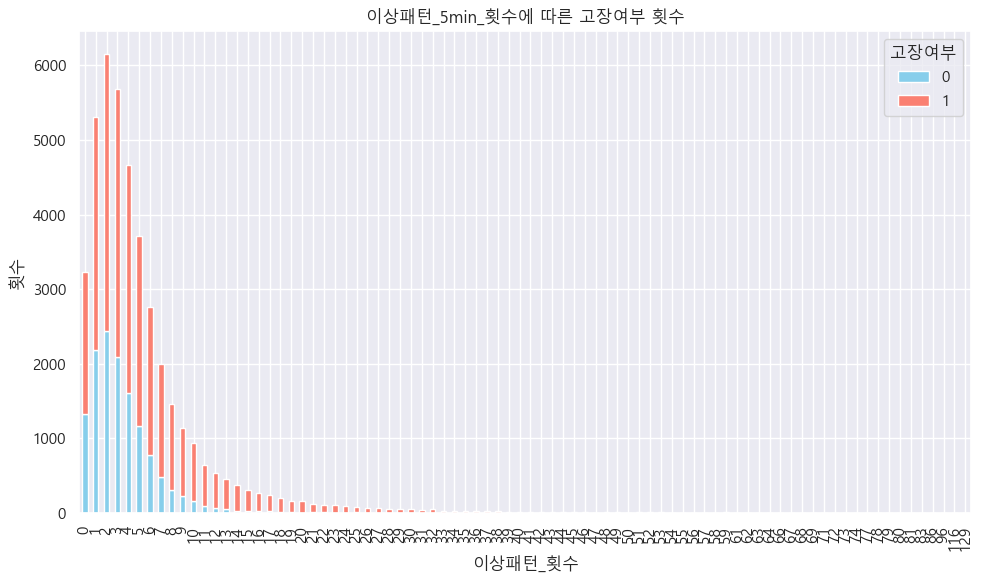

In [316]:
# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 결과 시각화
result = df_Bike_latest_2.groupby('이상패턴_5min_횟수')['고장여부'].value_counts().unstack().fillna(0)
result.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xlabel('이상패턴_횟수')
plt.ylabel('횟수')
plt.title('이상패턴_5min_횟수에 따른 고장여부 횟수')
plt.legend(title='고장여부')
plt.tight_layout()
plt.show()

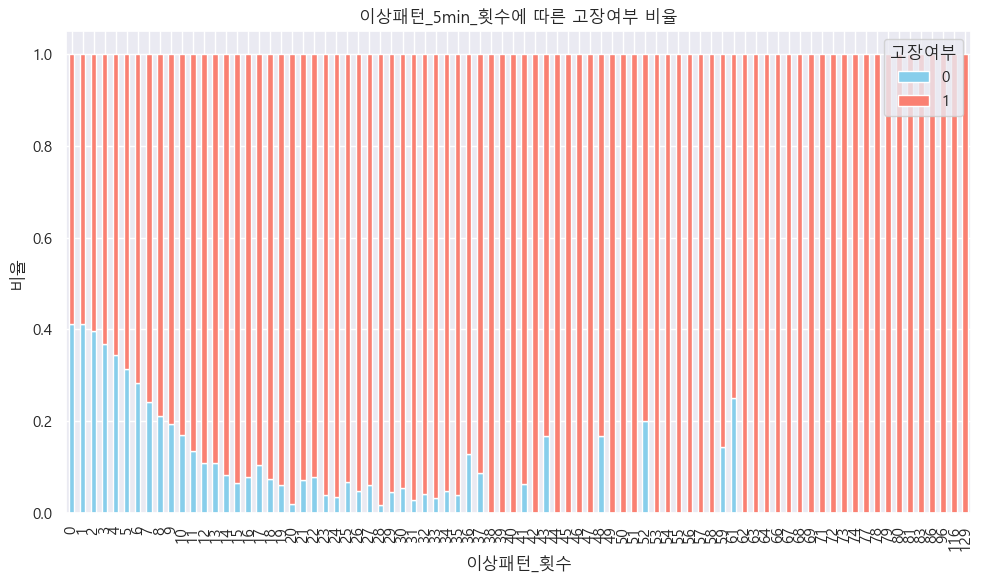

In [318]:
# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 결과 시각화
result = df_Bike_latest_2.groupby('이상패턴_5min_횟수')['고장여부'].value_counts(normalize=True).unstack().fillna(0)
#result = df_Bike_latest_2.groupby('이상패턴_횟수')['고장여부'].value_counts().unstack().fillna(0)
result.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xlabel('이상패턴_횟수')
plt.ylabel('비율')
plt.title('이상패턴_5min_횟수에 따른 고장여부 비율')
plt.legend(title='고장여부')
plt.tight_layout()
plt.show()

In [320]:
df_Bike_latest_2.head(5)

,자전거번호,이전일자_1mon,등록대여일자,고장구분,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
0,SPB-30006,2024-02-29,2024-03-31,페달,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167,-42.41,-63.32
1,SPB-30010,2024-05-18,2024-06-18,타이어,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667,-4.54,-1.83
2,SPB-30014,2024-05-24,2024-06-24,기타,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455,54.46,45.17
3,SPB-30018,2024-05-01,2024-06-01,기타,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364,80.77,75.37
4,SPB-30022,2024-04-20,2024-05-20,기타,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000,84.99,84.98


In [322]:
df_Bike_latest_3 = pd.get_dummies(df_Bike_latest_2, columns=['고장구분'])

In [324]:
df_Bike_latest_3.head(3)

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
0,SPB-30006,2024-02-29,2024-03-31,1,2,98170.92,843.0,74.0,128.50,1978.381926,267667.429167,-42.41,-63.32,False,False,False,False,False,False,True
1,SPB-30010,2024-05-18,2024-06-18,1,5,231653.56,2257.0,121.0,126.75,1770.825903,235976.111667,-4.54,-1.83,False,False,False,False,False,True,False
2,SPB-30014,2024-05-24,2024-06-24,1,7,335138.54,2966.0,156.0,101.00,2214.580818,230862.455455,54.46,45.17,False,True,False,False,False,False,False


In [326]:
df_Bike_latest_3.columns
df_Bike_latest_3[['고장여부',
       '이상패턴_5min_횟수', 
       '이전일자_1mon_이용거리', '이전일자_1mon_이용시간', '이전일자_1mon_이용횟수',
       '이용횟수_비교', '이용거리_비교',
       '고장구분_', '고장구분_기타 ', '고장구분_단말기', '고장구분_안장', '고장구분_체인', '고장구분_타이어 ',
       '고장구분_페달']].corr()

,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
고장여부,1.000000,0.195219,0.159495,0.155595,0.161655,-0.041076,-0.011514,-1.000000,0.336060,0.126268,0.258279,0.277682,0.272973,0.150117
이상패턴_5min_횟수,0.195219,1.000000,0.238178,0.244196,0.321413,0.074648,0.027009,-0.195219,-0.049694,0.028002,0.118246,0.149776,0.040209,-0.000358
이전일자_1mon_이용거리,0.159495,0.238178,1.000000,0.980019,0.957601,0.209158,0.117395,-0.159495,0.041205,0.011512,-0.034669,0.188674,0.000613,0.004888
이전일자_1mon_이용시간,0.155595,0.244196,0.980019,1.000000,0.963482,0.216829,0.119036,-0.155595,0.039043,0.017762,-0.034717,0.189258,-0.005200,0.003675
이전일자_1mon_이용횟수,0.161655,0.321413,0.957601,0.963482,1.000000,0.215239,0.108065,-0.161655,0.035048,0.008874,-0.025045,0.189317,-0.001542,0.010809
이용횟수_비교,-0.041076,0.074648,0.209158,0.216829,0.215239,1.000000,0.636524,0.041076,-0.026090,0.001069,-0.009473,0.021800,-0.031829,-0.011531
이용거리_비교,-0.011514,0.027009,0.117395,0.119036,0.108065,0.636524,1.000000,0.011514,-0.004541,0.012416,-0.007471,0.012157,-0.017520,-0.007114
고장구분_,-1.000000,-0.195219,-0.159495,-0.155595,-0.161655,0.041076,0.011514,1.000000,-0.336060,-0.126268,-0.258279,-0.277682,-0.272973,-0.150117
고장구분_기타,0.336060,-0.049694,0.041205,0.039043,0.035048,-0.026090,-0.004541,-0.336060,1.000000,-0.091750,-0.187675,-0.201773,-0.198352,-0.109080
고장구분_단말기,0.126268,0.028002,0.011512,0.017762,0.008874,0.001069,0.012416,-0.126268,-0.091750,1.000000,-0.070515,-0.075812,-0.074527,-0.040985


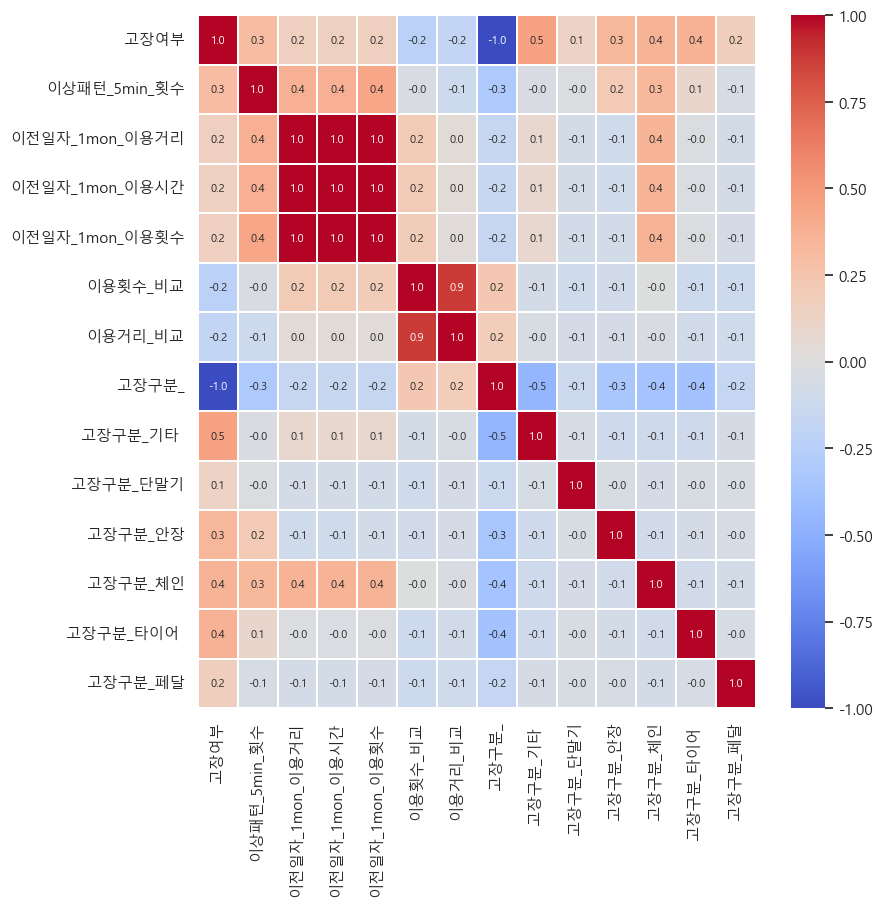

In [328]:
df_Bike_latest_4 = df_Bike_latest_3[['고장여부',
       '이상패턴_5min_횟수',
       '이전일자_1mon_이용거리', '이전일자_1mon_이용시간', '이전일자_1mon_이용횟수',
       '이용횟수_비교', '이용거리_비교',
       '고장구분_', '고장구분_기타 ', '고장구분_단말기', '고장구분_안장', '고장구분_체인', '고장구분_타이어 ',
       '고장구분_페달']].corr()

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

sns.heatmap(df_Bike_latest_4.corr(),
            annot = True,                     # 상관계수 표시
            annot_kws={"size": 8},
            fmt = '.1f',                      # 상관계수 소수점 자리
            cmap = 'coolwarm',                # 컬러맵 색상 팔레트
            vmax = 1.0,                       # 상관계수 최댓값
            vmin = -1,                       # 상관계수 최소값
            linecolor = 'white',              # 셀 테두리 색상
            linewidths = .005)                 # 셀 간격
sns.set(rc={'figure.figsize' : (9, 9)})       # 그래프 그리기

In [379]:
print(df_Bike_latest_3_2['이용거리_비교'].min())
print(df_Bike_latest_3_2['이용거리_비교'].max())

-100.0
77116.27


In [377]:
cond = df_Bike_latest_3_2['자전거번호'].isin(['SPB-35465', 'SPB-36015', 'SPB-37735', 'SPB-51246'])
df_Bike_latest_3_2 = df_Bike_latest_3_2[~cond]

In [381]:
df_Bike_latest_3_2[np.isinf(df_Bike_latest_3_2['이용거리_비교'])]['이용거리_비교']

Series([], Name: 이용거리_비교, dtype: float64)

---
## 선형회귀 모델링

In [383]:
df_Bike_latest_3_2.head(3)

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
0,SPB-30006,2024-02-29,2024-03-31,1,2,98170.92,843.0,74.0,128.50,1978.381926,267667.429167,-42.41,-63.32,False,False,False,False,False,False,True
1,SPB-30010,2024-05-18,2024-06-18,1,5,231653.56,2257.0,121.0,126.75,1770.825903,235976.111667,-4.54,-1.83,False,False,False,False,False,True,False
2,SPB-30014,2024-05-24,2024-06-24,1,7,335138.54,2966.0,156.0,101.00,2214.580818,230862.455455,54.46,45.17,False,True,False,False,False,False,False


In [385]:
np.array(df_Bike_latest_3_2['고장여부'])

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [527]:
def check_LinearRegression():
    plt.figure(figsize=(15, 6))

    # 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    
    _columns = ['이상패턴_5min_횟수', '이전일자_1mon_이용횟수', '이용횟수_비교']
    #_column = '이용횟수_비교'

    for _column in _columns:
        df_Bike_latest_3 = df_Bike_latest_3_2[df_Bike_latest_2[_column] > 0]
        X = np.array(df_Bike_latest_3_2[_column]).reshape(-1, 1)
        y = np.array(df_Bike_latest_3_2['고장여부'])
        
        # 데이터셋을 학습 세트와 테스트 세트로 분리
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # 테스트 세트에 대한 예측
        y_pred = model.predict(X_test)
        
        # 결과 시각화
        plt.scatter(X_test, y_test, color='blue', label='Actual')
        plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
        plt.xlabel(_column)
        plt.ylabel('고장여부')
        plt.title(_column + '에 따른 고장여부 예측')
        plt.legend()
        plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13888\2343134391.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_Bike_latest_3 = df_Bike_latest_3_2[df_Bike_latest_2[_column] > 0]


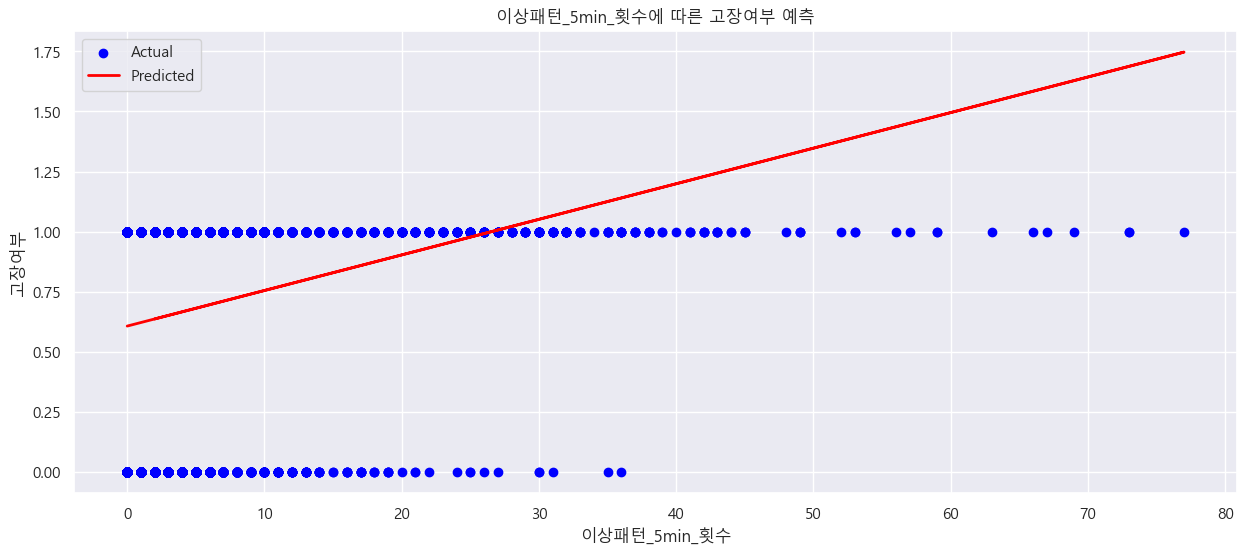

C:\Users\user\AppData\Local\Temp\ipykernel_13888\2343134391.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_Bike_latest_3 = df_Bike_latest_3_2[df_Bike_latest_2[_column] > 0]


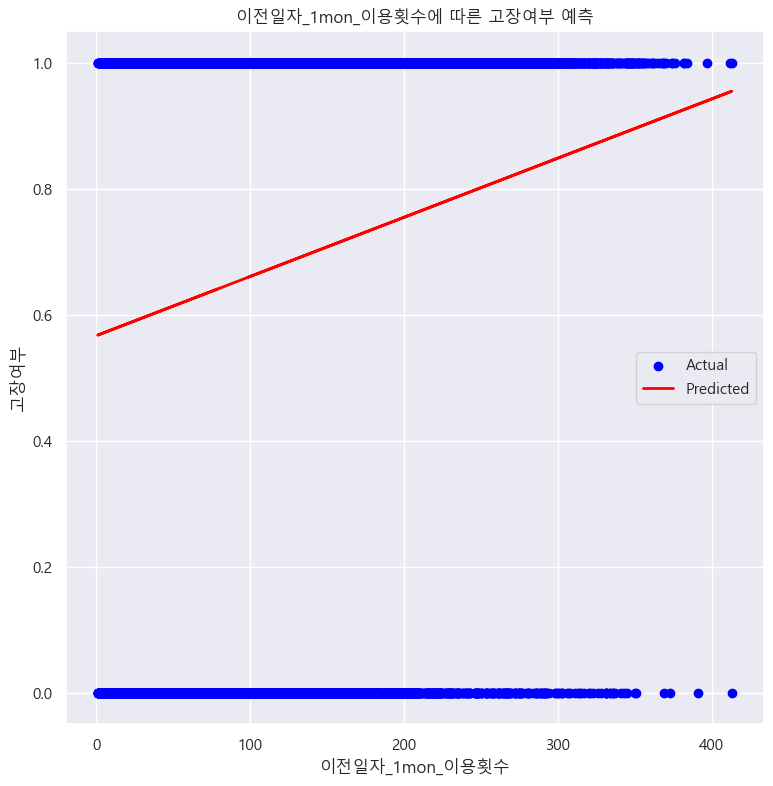

C:\Users\user\AppData\Local\Temp\ipykernel_13888\2343134391.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_Bike_latest_3 = df_Bike_latest_3_2[df_Bike_latest_2[_column] > 0]


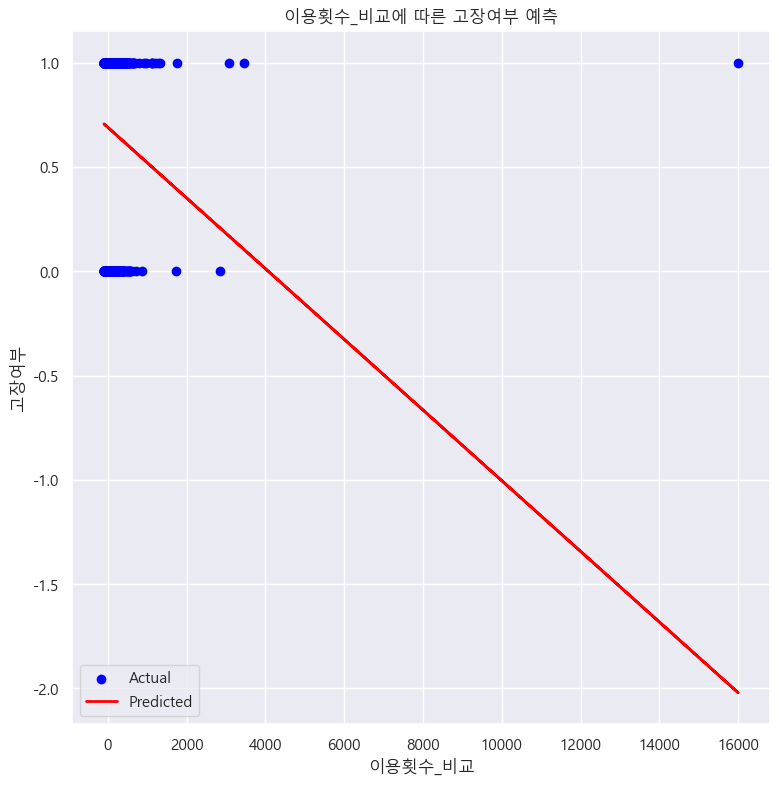

In [531]:
check_LinearRegression()

C:\Users\user\AppData\Local\Temp\ipykernel_13888\2474711613.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_Bike_latest_3 = df_Bike_latest_3_2[df_Bike_latest_2[_column] > 0]


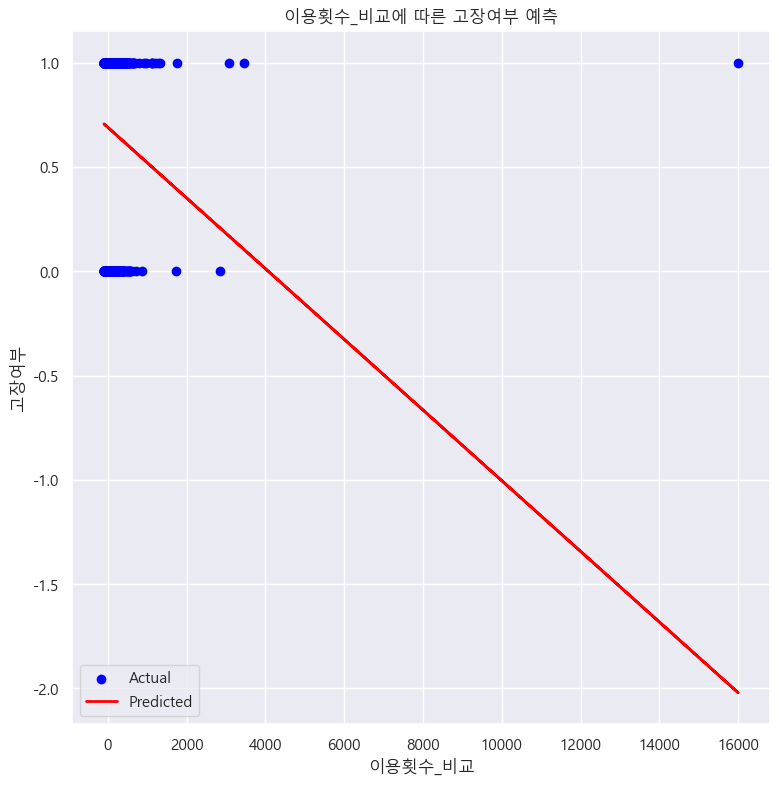

회귀 계수: [-0.00016934]
절편: 0.689485867459897


In [521]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# _columns = ['이상패턴_5min_횟수', '이전일자_1mon_이용횟수', '이용횟수_비교']
_column = '이용횟수_비교'

df_Bike_latest_3 = df_Bike_latest_3_2[df_Bike_latest_2[_column] > 0]
X = np.array(df_Bike_latest_3_2[_column]).reshape(-1, 1)
y = np.array(df_Bike_latest_3_2['고장여부'])

# 데이터셋을 학습 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측
y_pred = model.predict(X_test)

# 결과 시각화
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel(_column)
plt.ylabel('고장여부')
plt.title(_column + '에 따른 고장여부 예측')
plt.legend()
plt.show()

# 회귀 계수 출력
print('회귀 계수:', model.coef_)
print('절편:', model.intercept_)

In [393]:
df_Bike_latest_3.isnull().mean()

자전거번호                 0.0
이전일자_1mon             0.0
등록대여일자                0.0
고장여부                  0.0
이상패턴_5min_횟수          0.0
이전일자_1mon_이용거리        0.0
이전일자_1mon_이용시간        0.0
이전일자_1mon_이용횟수        0.0
대여일자_count(mean)      0.0
이용거리(M)_mean(mean)    0.0
이용거리(M)_sum(mean)     0.0
이용횟수_비교               0.0
이용거리_비교               0.0
고장구분_                 0.0
고장구분_기타               0.0
고장구분_단말기              0.0
고장구분_안장               0.0
고장구분_체인               0.0
고장구분_타이어              0.0
고장구분_페달               0.0
dtype: float64

In [395]:
df_Bike_latest_3_2 = df_Bike_latest_3_2.dropna()

In [397]:
df_Bike_latest_3_2.shape[0]

41506

In [399]:
df_Bike_latest_3_2.isnull().sum()

자전거번호                 0
이전일자_1mon             0
등록대여일자                0
고장여부                  0
이상패턴_5min_횟수          0
이전일자_1mon_이용거리        0
이전일자_1mon_이용시간        0
이전일자_1mon_이용횟수        0
대여일자_count(mean)      0
이용거리(M)_mean(mean)    0
이용거리(M)_sum(mean)     0
이용횟수_비교               0
이용거리_비교               0
고장구분_                 0
고장구분_기타               0
고장구분_단말기              0
고장구분_안장               0
고장구분_체인               0
고장구분_타이어              0
고장구분_페달               0
dtype: int64

In [401]:
df_Bike_latest_3_2.head()

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
0,SPB-30006,2024-02-29,2024-03-31,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167,-42.41,-63.32,False,False,False,False,False,False,True
1,SPB-30010,2024-05-18,2024-06-18,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667,-4.54,-1.83,False,False,False,False,False,True,False
2,SPB-30014,2024-05-24,2024-06-24,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455,54.46,45.17,False,True,False,False,False,False,False
3,SPB-30018,2024-05-01,2024-06-01,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364,80.77,75.37,False,True,False,False,False,False,False
4,SPB-30022,2024-04-20,2024-05-20,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000,84.99,84.98,False,True,False,False,False,False,False


In [403]:
df_Bike_latest_3_2.isnull().sum()

자전거번호                 0
이전일자_1mon             0
등록대여일자                0
고장여부                  0
이상패턴_5min_횟수          0
이전일자_1mon_이용거리        0
이전일자_1mon_이용시간        0
이전일자_1mon_이용횟수        0
대여일자_count(mean)      0
이용거리(M)_mean(mean)    0
이용거리(M)_sum(mean)     0
이용횟수_비교               0
이용거리_비교               0
고장구분_                 0
고장구분_기타               0
고장구분_단말기              0
고장구분_안장               0
고장구분_체인               0
고장구분_타이어              0
고장구분_페달               0
dtype: int64

In [405]:
df_Bike_latest_3_2.isnull().sum()

자전거번호                 0
이전일자_1mon             0
등록대여일자                0
고장여부                  0
이상패턴_5min_횟수          0
이전일자_1mon_이용거리        0
이전일자_1mon_이용시간        0
이전일자_1mon_이용횟수        0
대여일자_count(mean)      0
이용거리(M)_mean(mean)    0
이용거리(M)_sum(mean)     0
이용횟수_비교               0
이용거리_비교               0
고장구분_                 0
고장구분_기타               0
고장구분_단말기              0
고장구분_안장               0
고장구분_체인               0
고장구분_타이어              0
고장구분_페달               0
dtype: int64

In [407]:
np.array(df_Bike_latest_3_2[['이상패턴_5min_횟수', '이전일자_1mon_이용횟수', '이용횟수_비교', '이용거리_비교']]).reshape(-1, 4)

array([[  2.  ,  74.  , -42.41, -63.32],
       [  5.  , 121.  ,  -4.54,  -1.83],
       [  7.  , 156.  ,  54.46,  45.17],
       ...,
       [  4.  ,  43.  ,  82.33,  65.35],
       [  1.  ,   9.  , -53.25, -41.43],
       [  3.  ,  46.  ,  63.75,   0.27]])

In [417]:
df_Bike_latest_3_2.head()

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
0,SPB-30006,2024-02-29,2024-03-31,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167,-42.41,-63.32,False,False,False,False,False,False,True
1,SPB-30010,2024-05-18,2024-06-18,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667,-4.54,-1.83,False,False,False,False,False,True,False
2,SPB-30014,2024-05-24,2024-06-24,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455,54.46,45.17,False,True,False,False,False,False,False
3,SPB-30018,2024-05-01,2024-06-01,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364,80.77,75.37,False,True,False,False,False,False,False
4,SPB-30022,2024-04-20,2024-05-20,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000,84.99,84.98,False,True,False,False,False,False,False


In [419]:
df_Bike_latest_3_2.describe()

,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
count,41506,41506,41506.000000,41506.000000,4.150600e+04,41506.000000,41506.000000,41506.000000,41506.000000,41506.000000,41506.000000,41506.000000
mean,2024-04-23 05:39:05.819881472,2024-05-23 22:52:29.154339072,0.683443,5.244037,3.021850e+05,2667.363225,125.993760,110.701603,2183.173415,259844.532660,27.757437,39.400804
min,2023-12-01 00:00:00,2024-01-01 00:00:00,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.163738,33.754167,-99.410000,-100.000000
25%,2024-04-03 00:00:00,2024-05-03 00:00:00,0.000000,2.000000,1.232086e+05,1144.000000,65.000000,68.166667,1961.648541,147847.635417,-24.490000,-31.030000
50%,2024-05-09 00:00:00,2024-06-09 00:00:00,1.000000,4.000000,2.488199e+05,2216.000000,113.000000,111.454545,2176.903689,240322.242318,8.680000,7.295000
75%,2024-05-27 00:00:00,2024-06-27 00:00:00,1.000000,6.000000,4.233027e+05,3691.000000,174.000000,143.750000,2420.296962,337403.640777,49.190000,58.287500
max,2024-05-30 00:00:00,2024-06-30 00:00:00,1.000000,129.000000,1.283005e+06,11205.000000,438.000000,280.000000,6913.333333,853868.510000,19200.000000,77116.270000
std,NaN,NaN,0.465138,6.121461,2.280998e+05,1963.412034,78.761736,54.655010,395.348474,154591.184069,168.641309,566.478612


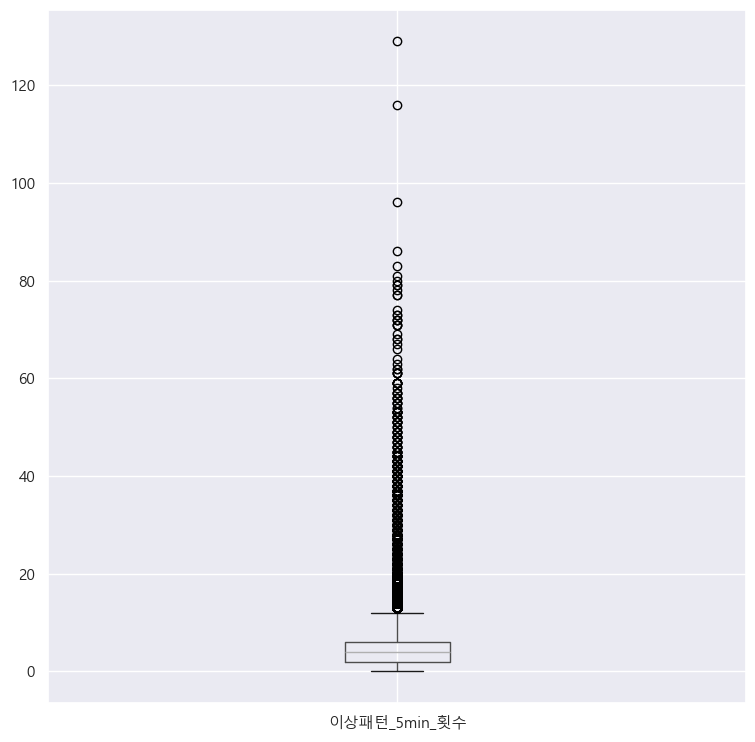

In [453]:
df_Bike_latest_3_2.boxplot(column=['이상패턴_5min_횟수'])
plt.show()

In [481]:
def check_outlier(_df, _column):
    # IQR 방법
    Q1 = _df[_column].quantile(0.25)
    Q3 = _df[_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = _df[~((_df[_column] < lower_bound) | (_df[_column] > upper_bound))]
    
    return outliers

In [439]:
outliers

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
0,SPB-30006,2024-02-29,2024-03-31,1,2,98170.92,843.0,74.0,128.500000,1978.381926,267667.429167,-42.41,-63.32,False,False,False,False,False,False,True
1,SPB-30010,2024-05-18,2024-06-18,1,5,231653.56,2257.0,121.0,126.750000,1770.825903,235976.111667,-4.54,-1.83,False,False,False,False,False,True,False
2,SPB-30014,2024-05-24,2024-06-24,1,7,335138.54,2966.0,156.0,101.000000,2214.580818,230862.455455,54.46,45.17,False,True,False,False,False,False,False
3,SPB-30018,2024-05-01,2024-06-01,1,2,291259.65,3041.0,153.0,84.636364,1931.965198,166086.906364,80.77,75.37,False,True,False,False,False,False,False
4,SPB-30022,2024-04-20,2024-05-20,1,7,253399.66,2755.0,143.0,77.300000,1651.201903,136984.092000,84.99,84.98,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41556,SPB-84992,2024-05-30,2024-06-30,0,1,35200.00,279.0,12.0,17.583333,2286.489385,39012.665000,-31.75,-9.77,True,False,False,False,False,False,False
41557,SPB-84994,2024-05-21,2024-06-21,0,7,23153.80,249.0,30.0,30.454545,1954.571715,57844.540909,-1.49,-59.97,True,False,False,False,False,False,False
41558,SPB-84997,2024-05-28,2024-06-28,0,4,60815.51,564.0,43.0,23.583333,1426.646847,36779.604167,82.33,65.35,True,False,False,False,False,False,False
41559,SPB-84998,2024-05-25,2024-06-25,0,1,26810.00,139.0,9.0,19.250000,2181.895717,45776.485000,-53.25,-41.43,True,False,False,False,False,False,False


In [443]:
df_Bike_latest_3_2.describe()

,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교
count,41506,41506,41506.000000,41506.000000,4.150600e+04,41506.000000,41506.000000,41506.000000,41506.000000,41506.000000,41506.000000,41506.000000
mean,2024-04-23 05:39:05.819881472,2024-05-23 22:52:29.154339072,0.683443,5.244037,3.021850e+05,2667.363225,125.993760,110.701603,2183.173415,259844.532660,27.757437,39.400804
min,2023-12-01 00:00:00,2024-01-01 00:00:00,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.163738,33.754167,-99.410000,-100.000000
25%,2024-04-03 00:00:00,2024-05-03 00:00:00,0.000000,2.000000,1.232086e+05,1144.000000,65.000000,68.166667,1961.648541,147847.635417,-24.490000,-31.030000
50%,2024-05-09 00:00:00,2024-06-09 00:00:00,1.000000,4.000000,2.488199e+05,2216.000000,113.000000,111.454545,2176.903689,240322.242318,8.680000,7.295000
75%,2024-05-27 00:00:00,2024-06-27 00:00:00,1.000000,6.000000,4.233027e+05,3691.000000,174.000000,143.750000,2420.296962,337403.640777,49.190000,58.287500
max,2024-05-30 00:00:00,2024-06-30 00:00:00,1.000000,129.000000,1.283005e+06,11205.000000,438.000000,280.000000,6913.333333,853868.510000,19200.000000,77116.270000
std,NaN,NaN,0.465138,6.121461,2.280998e+05,1963.412034,78.761736,54.655010,395.348474,154591.184069,168.641309,566.478612


In [455]:
outliers.head(2)

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
0,SPB-30006,2024-02-29,2024-03-31,1,2,98170.92,843.0,74.0,128.50,1978.381926,267667.429167,-42.41,-63.32,False,False,False,False,False,False,True
1,SPB-30010,2024-05-18,2024-06-18,1,5,231653.56,2257.0,121.0,126.75,1770.825903,235976.111667,-4.54,-1.83,False,False,False,False,False,True,False


In [457]:
outliers['고장여부'].value_counts()

고장여부
1    26659
0    12272
Name: count, dtype: int64

In [463]:
outliers0 = outliers[outliers['고장여부'] == 0][:10000]
outliers1 = outliers[outliers['고장여부'] == 1][:10000]
outliers_2 = pd.concat([outliers0, outliers1], axis=0)
outliers_2

,자전거번호,이전일자_1mon,등록대여일자,고장여부,이상패턴_5min_횟수,이전일자_1mon_이용거리,이전일자_1mon_이용시간,이전일자_1mon_이용횟수,대여일자_count(mean),이용거리(M)_mean(mean),이용거리(M)_sum(mean),이용횟수_비교,이용거리_비교,고장구분_,고장구분_기타,고장구분_단말기,고장구분_안장,고장구분_체인,고장구분_타이어,고장구분_페달
28418,SPB-30001,2024-05-28,2024-06-28,0,5,240874.96,2496.0,161.0,128.333333,2256.445161,292072.531667,25.45,-17.53,True,False,False,False,False,False,False
28419,SPB-30008,2024-04-20,2024-05-20,0,0,228641.47,1732.0,87.0,96.916667,2228.937312,231055.877500,-10.23,-1.04,True,False,False,False,False,False,False
28420,SPB-30032,2024-05-30,2024-06-30,0,3,66916.90,1216.0,65.0,113.272727,1101.784391,133250.847273,-42.62,-49.78,True,False,False,False,False,False,False
28421,SPB-30055,2024-05-28,2024-06-28,0,3,169441.86,1834.0,112.0,142.500000,1717.902613,250861.035000,-21.40,-32.46,True,False,False,False,False,False,False
28422,SPB-30058,2024-05-30,2024-06-30,0,0,237741.17,2018.0,124.0,118.000000,1962.993168,246294.343333,5.08,-3.47,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11064,SPB-47121,2024-05-12,2024-06-12,1,5,239200.00,1859.0,95.0,66.333333,1992.687046,142601.763333,43.22,67.74,False,False,False,True,False,False,False
11066,SPB-47123,2024-04-17,2024-05-17,1,6,241319.35,2204.0,107.0,67.083333,2231.117191,156337.359167,59.50,54.36,False,False,False,True,False,False,False
11067,SPB-47124,2024-05-07,2024-06-07,1,6,237220.67,1632.0,81.0,70.545455,2196.990042,159991.847273,14.82,48.27,False,False,False,True,False,False,False
11068,SPB-47125,2023-12-30,2024-01-30,1,3,67769.04,517.0,44.0,53.000000,1864.401249,106629.491667,-16.98,-36.44,False,False,False,True,False,False,False


---
## 로지스틱회귀 모델링

16000 4000 16000 4000


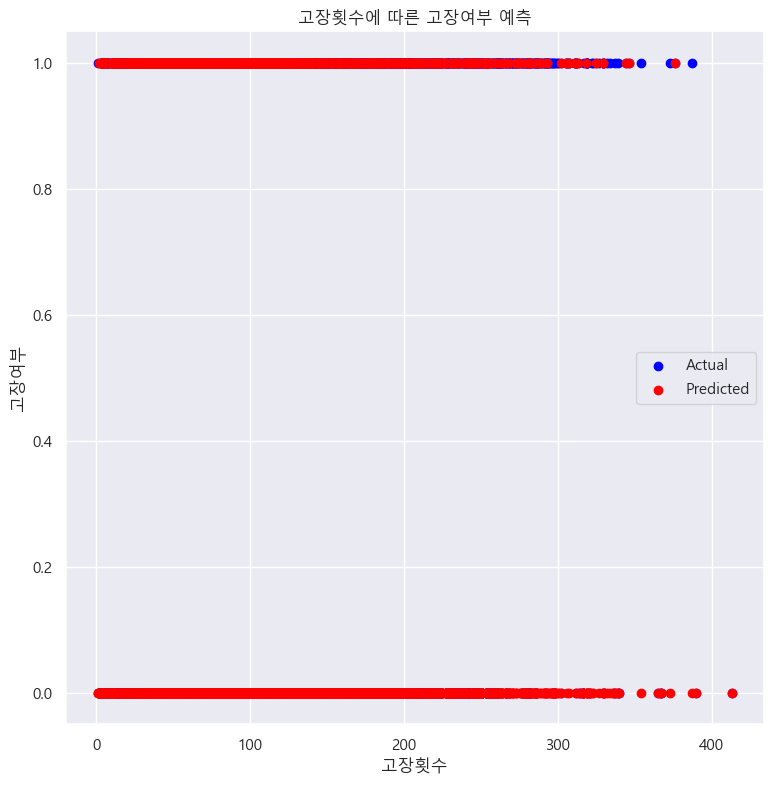

테스트 세트 정확도: 0.59
confusion_matrix :  [[1411  589]
 [1051  949]]
classification_report :                precision    recall  f1-score   support

           0       0.57      0.71      0.63      2000
           1       0.62      0.47      0.54      2000

    accuracy                           0.59      4000
   macro avg       0.60      0.59      0.58      4000
weighted avg       0.60      0.59      0.58      4000

Accuracy: 0.59
F1 Score: 0.5364612775579424
Log Loss: 0.6688104579012029


In [507]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, log_loss

# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# '이상패턴_5min_횟수', '이전일자_1mon_이용횟수', '이용횟수_비교', '이용거리_비교'
_columns = ['이상패턴_5min_횟수', '이전일자_1mon_이용횟수', '이용횟수_비교']
X = np.array(outliers_2[_columns]).reshape(-1, len(_columns))
y = np.array(outliers_2['고장여부'])

# 데이터셋을 학습 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=444, stratify=y)
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 결과 시각화
plt.scatter(X_test[:, 1], y_test, color='blue', label='Actual')
plt.scatter(X_test[:, 1], y_pred, color='red', label='Predicted')
plt.xlabel('고장횟수')
plt.ylabel('고장여부')
plt.title('고장횟수에 따른 고장여부 예측')
plt.legend()
plt.show()

# 모델 평가
print('테스트 세트 정확도:', model.score(X_test, y_test))
print('confusion_matrix : ', confusion_matrix(y_test, y_pred))
print('classification_report : ', classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_prob))


In [503]:
# 회귀 계수 출력
print('회귀 계수:', model.coef_)
print('절편:', model.intercept_)

회귀 계수: [[ 0.15663628  0.0075919  -0.01412557]]
절편: [-0.60212339]


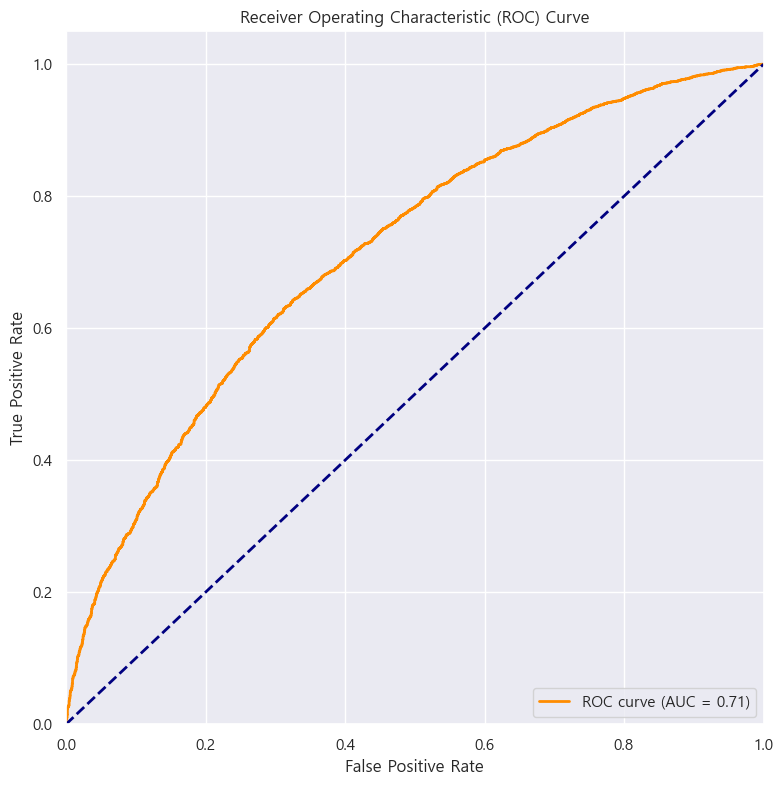

In [505]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### [ 이상패턴 횟수 == 0 ] 것들의 고장여부 비율

In [972]:
counts = df_Bike_latest_2[df_Bike_latest_2['이상패턴_5min_횟수'] == 0]['고장여부'].value_counts()
total = counts.sum()   # 총 데이터 개수
percentage = counts / total * 100   # 비율 계산
print(f'total : {total}')
print(f'counts : {counts}')
print(f'percentage : {percentage}')

total : 1056
counts : 고장여부
0    585
1    471
Name: count, dtype: int64
percentage : 고장여부
0    55.397727
1    44.602273
Name: count, dtype: float64
